# **Malaria Cell Detection Using Deep Learning and PyTorch**
So this projects detects malaria cell with aprrox 95% accuracy. I have used Convolutional Neural Network (CNN) with ResNet9 architecture for this project.Along with all this i have also used Normalization and Data Augmentation to increase the accuracy percentage.
The Dataset is used from kaggle.com.

The Steps involved in this project-
1.   Picking a Dataset
2.   Dwonloading a Dataset
3.   Import the Dataset using PyTorch
4.   Prepare the Dataset for Training
5.   Move the Dataset to the GPU
6.   Define Neural Networks
7.   Train the Model
8.   Make Predictions on sample images iterate on it with different networks and hyperparameters.

You can Download the Dataset from here - https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria






We will start by importing all the necessary tools for this project

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline




After importing all the necessary tools we will name our project and download the dataset using opendatasets library.


In [ ]:
project_name='MalariaDetection'

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria'

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vishnutalwar
Your Kaggle Key: ··········


100%|██████████| 675M/675M [00:03<00:00, 178MB/s]


In [ ]:
data_dir = './cell-images-for-detecting-malaria/cell_images'

We will list out all the folders in the directory which we downloaded

In [ ]:
os.listdir(data_dir)

['Parasitized', 'Uninfected', 'cell_images']

Although the directory only contains 2 folder i.e, Parasitized and Uninfected, some times directory makes it own sub-folder in side it. As you can see in above, to cope this problem we will include a 'if' statement and remove it if it is present.

In [ ]:
import shutil
if os.path.exists(data_dir + '/cell_images'):
  shutil.rmtree(data_dir + '/cell_images')


In [ ]:
os.listdir(data_dir)

['Parasitized', 'Uninfected']

Now we will see the number of images in each folder, in this case both folder contain equal number of images

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Parasitized : 13780
Uninfected : 13780


In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

27558

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=142x148 at 0x7FF59B04E880>, 0)

In [ ]:
dataset.classes

['Parasitized', 'Uninfected']

Let's see how the image looks like in the dataset.

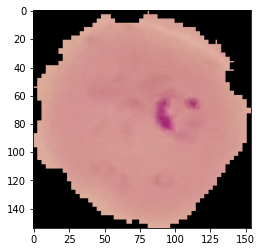

In [ ]:
img, label = dataset[10]
plt.imshow(img)

# Data Augmentation & Normalization
Here i am using data augmentation and normalization to improve our model's accuracy. In data augmentation  i have used horizontal flip which flips the image, Random Crop which crops the image.Then i have used predefined stats for normalization.

In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomHorizontalFlip(),
                                            #tt.RandomRotation,
                                            
                                            tt.RandomCrop(64),
                                            tt.ToTensor(),
                                            tt.Normalize(*stats,inplace=True)
                                            ]))

Let's See how the image looks like after all this

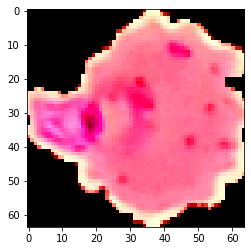

In [ ]:
img, label = dataset[120]
plt.imshow(img.permute((1,2,0)))

# Making Training and Validation Dataset.

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_size, val_size

(24803, 2755)

In [ ]:
train_ds , valid_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(valid_ds)

(24803, 2755)

# Making Dataloaders.
After making datasets we load them in dataloaders using 'Dataloader' function of pytorch.

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers = 2,
                      pin_memory = True)
val_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers = 2,
                    pin_memory=True)

Loading batch of images 

In [ ]:
def show_batch(dl): #with normalization
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

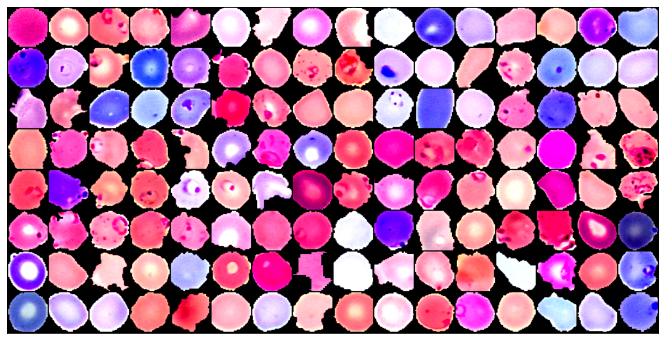

In [ ]:
show_batch(train_dl)

# Use of GPU.
As our dataset is large, it is always good to train any machine learning model on because it will train faster. GPU contain thousands of CUDA cores which in this case pytorch utilize fully. Colab has free GPU, you can change it on "Runtime" option, but if you are running locally either you should have a GPU or rent it on websites like GCP, AWS, VAST Ai etc.

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.device

device(type='cpu')

we will shift our dataloader to the device i.e, GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

# Define the Model.
I have used convolutional neural network(CNN) and ResNet9 Architecture, using the nn.Conv2d class from PyTorch for this project.

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Training the Model
We'll define two functions that are fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

The Convolutional network Block

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

Shifting the model to ResNet9 Architecture

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, label = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 2])


Before start of training  let's see how our model performs on the validation set with the initial set of parameters.

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.699810802936554, 'val_acc': 0.47031354904174805}]

Now lets train the model for 5 epoch, setting the learning rate at 0.001 and using Adam alogirithm.


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4135, val_loss: 0.1580, val_acc: 0.9454
Epoch [1], train_loss: 0.1723, val_loss: 0.1706, val_acc: 0.9401
Epoch [2], train_loss: 0.1614, val_loss: 0.1394, val_acc: 0.9514
Epoch [3], train_loss: 0.1465, val_loss: 0.1484, val_acc: 0.9443
Epoch [4], train_loss: 0.1393, val_loss: 0.1309, val_acc: 0.9550


Plotting the accuracy

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

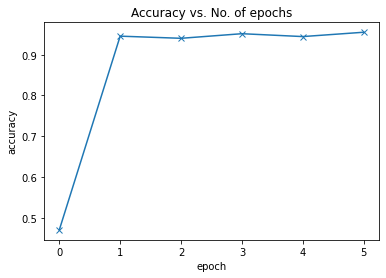

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

Plotting the losses(training & validation)

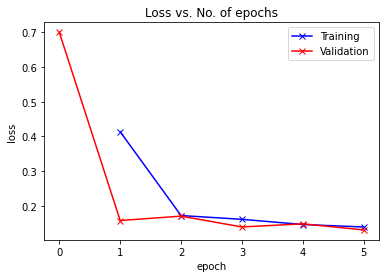

In [ ]:
plot_losses(history)

Saving the Notebook


In [ ]:
!pip install jovian --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import jovian

In [ ]:
jovian.commit(project='malariadetectioncell')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


# Predicting The Image

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Now we will predict the image while showing it. We will print the target image which the image actually belongs to the class and also print the prediction which our model predicts.

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)



As you can see model predicted correctly

Target: Parasitized
Prediction: Parasitized


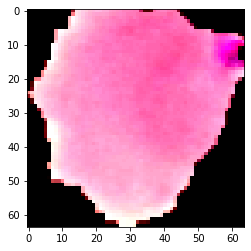

In [ ]:
show_image_prediction(*valid_ds[277])

# Saving the Model
below code saves the model weights not the whole model, Pytorch recommends saving the weights of model instead of whole model as it can lead to some errors in future if your model is complicated.

In order to load the whole model you have to reinitalize the model and load the saved weights file i.e, 'MalaraiaCellDetection-Resnet9.pth' into it.

In [ ]:
torch.save(model.state_dict(), 'MalaraiaCellDetection-Resnet9.pth')

In [ ]:
jovian.commit(project='malariacelldetection', environment=None, outputs=['MalaraiaCellDetection-Resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


# Conclusion
By using convolutional neural network and Resnet9 we have achieved accuracy around 95%. After tweaking the hyperparameters, we can even take it further.
Although Data Augmentation and Normalization were not necessary for this case as the model was giving almsot same results without it but it can surely improve accuracy for other projects and reduce overfitting.

# Summary


*   Introduction to the Model and dataset.
*   Downloading and loading images as dataset using torchvision
*   Tacking sub-folder problem
*   Showing random batch of images in dataset
*   Use of GPU
*   Creating Convolutional layers 
*   Defining the model 
*   Training the model and Plotting losses
*   Prediciting the image
*   Saving the Model









